OpenCV로 배경 제거 해보기

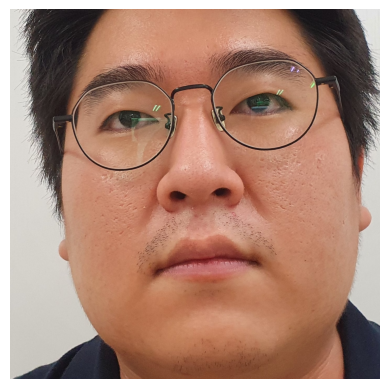

In [8]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../../Face_data3/0000/3.jpg")
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

In [10]:
import numpy as np
# 배경을 제거하고자 하는 전경 주위에 사각형 박스를 그리고 grabCut 알고리즘 적용

# 사각영역 : x, y, width, height
rect = (0, 56, 1418, 1417)

# 초기 마스크 생성
mask1 = np.zeros(image_rgb.shape[:2], np.uint8)

# grabCut에 사용할 임시 배열 생성
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# grabCut 실행
cv2.grabCut(image_rgb, # 원본이미지
            mask1, # 마스크
            rect, # 사각영역
            bgdModel, # 배경을 위한 임시 배열
            fgdModel, # 전경을 위한 임시 배열
            50, # 반복횟수
            cv2.GC_INIT_WITH_RECT) # 사각 영역으로 초기화

# 배경인 곳은 0, 그 외에는 1로 설정한 마스크 생성
mask2 = np.where((mask1==2) | (mask1==0), 0, 1).astype('uint8')
image_rgb_nobg = image_rgb * mask2[:, :, np.newaxis]

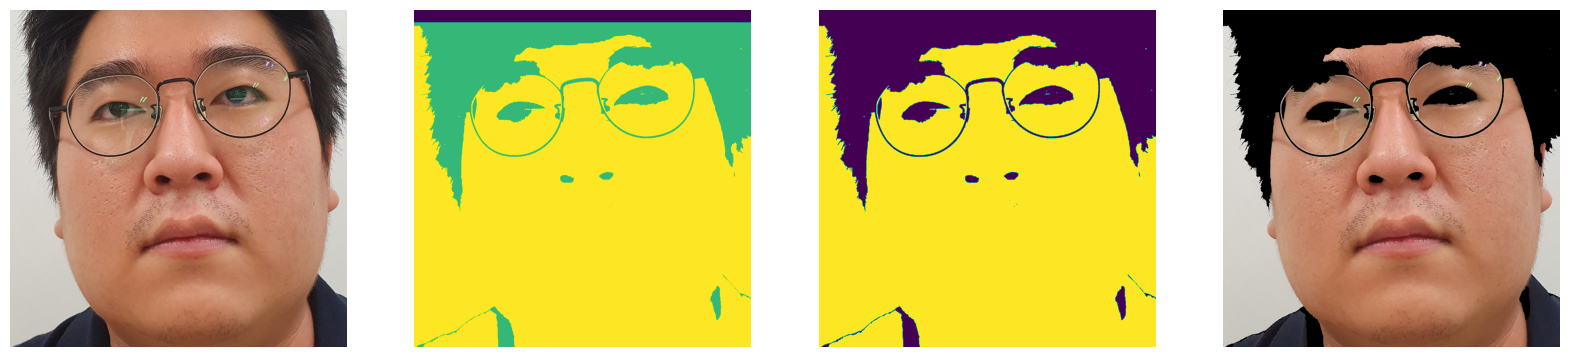

In [11]:
plt.figure(figsize=(20,6))
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(mask1)
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(mask2)
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(image_rgb_nobg)
plt.axis("off")
plt.show()

MediaPipe 배경 제거

In [12]:
import mediapipe as mp
import numpy as np
import cv2
import matplotlib.pyplot as plt

change_background_mp = mp.solutions.selfie_segmentation
change_bg_segment = change_background_mp.SelfieSegmentation()

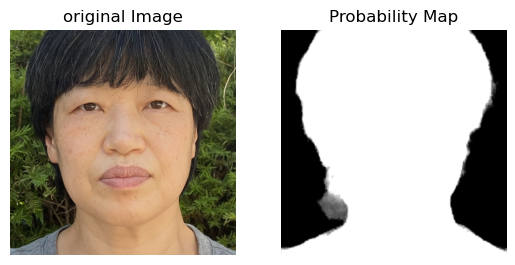

In [29]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread("../../Face_data2/0915012/1.jpg")
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = change_bg_segment.process(image_rgb)

plt.subplot(121); plt.imshow(image_rgb); plt.title('original Image');plt.axis('off');
plt.subplot(122); plt.imshow(result.segmentation_mask, cmap='gray'); plt.title("Probability Map"); plt.axis('off');




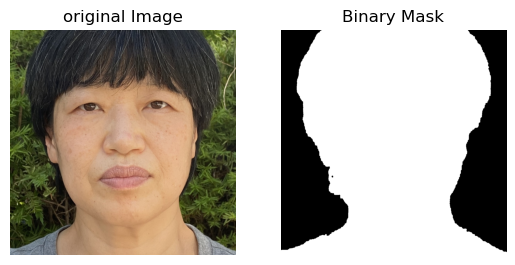

In [30]:
binary_mask = result.segmentation_mask > 0.9

plt.subplot(121);plt.imshow(image_rgb);plt.title('original Image');plt.axis('off'); 
plt.subplot(122);plt.imshow(binary_mask, cmap='gray');plt.title("Binary Mask");plt.axis('off');

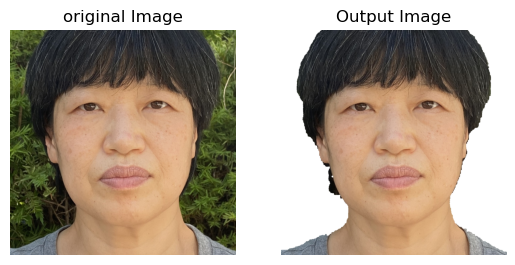

In [31]:
binary_mask_3 = np.dstack((binary_mask, binary_mask, binary_mask))

output_image = np.where(binary_mask_3, image_rgb, 255)

plt.subplot(121);plt.imshow(image_rgb);plt.title('original Image');plt.axis('off'); 
plt.subplot(122);plt.imshow(output_image);plt.title("Output Image");plt.axis('off');

배경제거 자동화

In [8]:
import cv2
import glob
import os
import mediapipe as mp
import numpy as np

def detect_face(path, save_path, split_num):
    count_num = 0  # 카운트 숫자 초기화

    split_num = split_num

    # 저장할 폴더 경로
    folder_path = save_path

    # 저장 폴더가 없다면 생성
    if not os.path.exists(f'{folder_path}'):
        os.makedirs(folder_path, exist_ok=True)

    # 배경 검출
    change_background_mp = mp.solutions.selfie_segmentation
    change_bg_segment = change_background_mp.SelfieSegmentation(model_selection=1)

    last_folder_name = None  # 이전 폴더명 초기값



    for face_path in glob.glob(path, recursive=True):
        path_split = face_path.split('\\')
        print(path_split[-1])

        # 저장할 폴더 이름 초기화
        folder_name = path_split[split_num]

        if path_split[-1] == '':
            path_split.remove('')

        try:
            if path_split[-1].split('.')[-1].lower() == 'jpg':
                # 이미지 로드
                image = cv2.imread(face_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                result = change_bg_segment.process(image_rgb)
                binary_mask = result.segmentation_mask > 0.2
                binary_mask_3 = np.dstack((binary_mask, binary_mask, binary_mask))
                output_image = np.where(binary_mask_3, image_rgb, 255)
                
                if folder_name != last_folder_name:
                    count_num = 0  # 카운트 숫자 초기화
                    if not os.path.exists(f'{folder_path}/{folder_name}'): # 폴더가 없다면                         
                        os.makedirs(f'{folder_path}/{folder_name}', exist_ok=True)  # 폴더 생성
                        print(f'{folder_name} 폴더 생성')

                    # 얼굴 이미지를 JPG 파일로 저장
                    count_num += 1
                    cv2.imwrite(f'{folder_path}/{folder_name}/{count_num}.jpg', output_image[:,:,::-1])
                    print('저장 완료')

                else:
                    # 얼굴 이미지를 JPG 파일로 저장
                    count_num += 1
                    cv2.imwrite(f'{folder_path}/{folder_name}/{count_num}.jpg', output_image[:,:,::-1])
                    print('동일 인물 추가 사진 저장 완료')
                
                # 마지막 폴더명 저장
                last_folder_name = folder_name

            else:
                print('이미지 파일이 아님')
            
        except Exception as e:
            print(e)
            pass

In [9]:
path = "D:\\workspace_kitae\\MainProject\\ImageProject\\Face_data2\\**"
save_path = "D:\\workspace_kitae\\MainProject\\ImageProject\\Face_data_no_bg3"
detect_face(path, save_path, 5) 
# detect_face(변환할 폴더 경로, 저장할 폴더 경로 (없으면 생성됨), 사람마다 구분된 폴더명 인덱스번호)


이미지 파일이 아님
0000
이미지 파일이 아님
1.jpg
0000 폴더 생성
저장 완료
2.jpg
동일 인물 추가 사진 저장 완료
3.jpg
동일 인물 추가 사진 저장 완료
4.jpg
동일 인물 추가 사진 저장 완료
5.jpg
동일 인물 추가 사진 저장 완료
6.jpg
동일 인물 추가 사진 저장 완료
7.jpg
동일 인물 추가 사진 저장 완료
8.jpg
동일 인물 추가 사진 저장 완료
9.jpg
동일 인물 추가 사진 저장 완료
0001
이미지 파일이 아님
1.jpg
0001 폴더 생성
저장 완료
2.jpg
동일 인물 추가 사진 저장 완료
3.jpg
동일 인물 추가 사진 저장 완료
4.jpg
동일 인물 추가 사진 저장 완료
5.jpg
동일 인물 추가 사진 저장 완료
6.jpg
동일 인물 추가 사진 저장 완료
7.jpg
동일 인물 추가 사진 저장 완료
8.jpg
동일 인물 추가 사진 저장 완료
9.jpg
동일 인물 추가 사진 저장 완료
0002
이미지 파일이 아님
1.jpg
0002 폴더 생성
저장 완료
2.jpg
동일 인물 추가 사진 저장 완료
3.jpg
동일 인물 추가 사진 저장 완료
4.jpg
동일 인물 추가 사진 저장 완료
5.jpg
동일 인물 추가 사진 저장 완료
6.jpg
동일 인물 추가 사진 저장 완료
7.jpg
동일 인물 추가 사진 저장 완료
8.jpg
동일 인물 추가 사진 저장 완료
9.jpg
동일 인물 추가 사진 저장 완료
0003
이미지 파일이 아님
1.jpg
0003 폴더 생성
저장 완료
2.jpg
동일 인물 추가 사진 저장 완료
3.jpg
동일 인물 추가 사진 저장 완료
4.jpg
동일 인물 추가 사진 저장 완료
5.jpg
동일 인물 추가 사진 저장 완료
6.jpg
동일 인물 추가 사진 저장 완료
7.jpg
동일 인물 추가 사진 저장 완료
8.jpg
동일 인물 추가 사진 저장 완료
9.jpg
동일 인물 추가 사진 저장 완료
0004
이미지 파일이 아님
1.jpg
0004 폴더 생성
저장 완료
2.jpg
동일 인물 추가 사진 저장 완료
3